## Determining channel importance
PSD features, theta and alpha bands only

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA

# %matplotlib inline 
%matplotlib qt


In [2]:
#Import dataset
t_auc_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\AUC_only/AUC_df_1.pkl")
t_psd_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\PSD_only/PSD_df_1.pkl")
a_auc_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\AUC_only/AUC_df_2.pkl")
a_psd_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\PSD_only/PSD_df_2.pkl")

In [3]:
def apply_SVM_channel(auc_df,psd_df):
    channels_list = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    # bestF1 = {'F1 Score':0,'dataset':'','params':''}
    # test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.99, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')

    for i in range(32):
        #Select columns 
        y = psd_df.iloc[:,-1].values
        y1 = auc_df.iloc[:,-1].values
        psd_col_select = lambda y: [x for x in list(psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
        X = psd_df[psd_col_select(i+1)].values
        X1 = auc_df.iloc[:,i].values.reshape(-1,1)
        #Split into training and test sets
        for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
            X1_train, X1_test = X1[train_index],X1[test_index]
            y1_train, y1_test = y1[train_index],y1[test_index]
        #Fit transform on training data
        x_99_train = pca99.fit_transform(X_train)
        #Fit transform on test data
        x_99_test = pca99.transform(X_test)
        #Gridsearch
        grid99 = grid.fit(x_99_train,y_train)
        grid991 = grid.fit(X1_train,y1_train)
        #Classifiers 
        clf99 = svm.SVC(**grid99.best_params_)
        clf991 = svm.SVC(**grid991.best_params_)
        clf99.fit(x_99_train,y_train)
        clf991.fit(X1_train,y1_train)
        #y_pred
        y_99_pred = clf99.predict(x_99_test)
        y_991_pred = clf991.predict(X1_test)
        #F1 Score 
        f1Score = f1_score(y_test,y_99_pred,pos_label='T')
        f1Score1 = f1_score(y1_test,y_991_pred,pos_label='T')
        f1_scores.append(f1Score)
        f1_scores.append(f1Score1)
        #Channel list
        channels_list.append("".join(("Ch",str(i+1))))
        channels_list.append("".join(("aCh",str(i+1))))
    #Order lists 
    
    return channels_list,f1_scores 

In [4]:
t_channels,t_f1_scores = apply_SVM_channel(t_auc_df,t_psd_df)
a_channels,a_f1_scores = apply_SVM_channel(a_auc_df,a_psd_df)

In [5]:
#Sort the channels in descending order of F1 scores 
add_band = lambda channels_list,y: ["".join((x,"_",y)) for x in channels_list]
t_channels1 = add_band(t_channels,"t")
a_channels1 = add_band(a_channels,"a")

channels_list = np.array(t_channels1 + a_channels1)
f1_scores = np.array(t_f1_scores + a_f1_scores)

sorted_channels = channels_list[f1_scores.argsort()[::-1]] #in descending order, best scores first 

In [6]:
print(len(sorted_channels))

128


In [232]:
print(sorted_channels[:10])

['aCh19_t' 'Ch19_t' 'Ch22_t' 'aCh11_t' 'Ch24_a' 'Ch11_t' 'aCh15_t'
 'aCh24_a' 'aCh18_a' 'Ch27_a']


In [233]:
sorted_channels[:10]

array(['aCh19_t', 'Ch19_t', 'Ch22_t', 'aCh11_t', 'Ch24_a', 'Ch11_t',
       'aCh15_t', 'aCh24_a', 'aCh18_a', 'Ch27_a'], dtype='<U7')

In [7]:
def create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,sorted_channels,no_channels):
    channels = sorted_channels[:no_channels]
    df_list = [0]*no_channels
    for (i,channel) in enumerate(channels):
        if channel[-1] == "t":
            if channel[0] == "a": #auc 
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                df_list[i] = t_auc_df.iloc[:,int(channel_no)-1]
            else: #psd
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                psd_col_select = lambda y: [x for x in list(t_psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
                df_list[i] = t_psd_df[psd_col_select(channel_no)]
        elif channel[-1] == "a":
            if channel[0] == "a": #auc 
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                df_list[i] = a_auc_df.iloc[:,int(channel_no)-1]
            else: #psd
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                psd_col_select = lambda y: [x for x in list(a_psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
                df_list[i] = a_psd_df[psd_col_select(channel_no)]
    df_list.append(t_auc_df.iloc[:,-1])
    return pd.concat(df_list,axis=1)
            

        


In [234]:
bestCh_df = create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,sorted_channels,10)
# bestCh_df.to_csv("F:\EEG-data\\think-count/check.csv")

In [235]:
bestCh_df.shape

(640, 26)

In [8]:
def PCA_CV_SVM(bestChdf):
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    # bestF1 = {'F1 Score':0,'dataset':'','params':''}
    # test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.999, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')
    y = bestChdf.iloc[:,-1].values
    X = bestChdf.iloc[:,:-1].values
    #Split into training and test sets
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index],X[test_index]
        y_train, y_test = y[train_index],y[test_index]
    #Fit transform on training data
    x_99_train = pca99.fit_transform(X_train)
    #Fit transform on test data
    x_99_test = pca99.transform(X_test)
    #Gridsearch
    grid99 = grid.fit(x_99_train,y_train)
    #Classifiers 
    clf99 = svm.SVC(**grid99.best_params_)
    clf99.fit(x_99_train,y_train)
    #y_pred
    y_99_pred = clf99.predict(x_99_test)
    #F1 Score 
    f1Score = f1_score(y_test,y_99_pred,pos_label='T')
    return f1Score



In [9]:
channels_f1Scores = [0]*len(sorted_channels)
for i in range(1,len(sorted_channels)+1):
    bestCh_df = create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,sorted_channels,i)
    channels_f1Scores[i-1] = PCA_CV_SVM(bestCh_df)

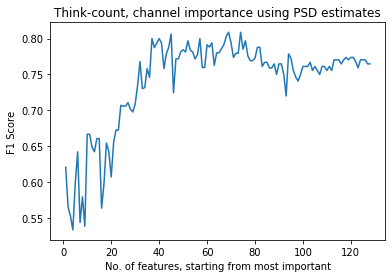

In [10]:
fig,ax = plt.subplots()
ax.plot(np.linspace(1,128,128),channels_f1Scores)
ax.set_xlabel("No. of features, starting from most important")
ax.set_ylabel("F1 Score")
ax.set_title("Think-count, channel importance using PSD estimates")
# ax.set_xticks(np.linspace(1,128,15))
plt.show()

In [258]:
maxF1 = max(channels_f1Scores)
print("Highest F1 score:",maxF1)

Highest F1 score: 0.8088235294117647


In [267]:
maxF1_channels = sorted_channels[:np.array(channels_f1Scores).argmax()]
print("No. of channels used to obtain highest F1 score:", len(maxF1_channels))
print("Channels used:",maxF1_channels)

No. of channels used to obtain highest F1 score: 68
Channels used: ['aCh19_t' 'Ch19_t' 'Ch22_t' 'aCh11_t' 'Ch24_a' 'Ch11_t' 'aCh15_t'
 'aCh24_a' 'aCh18_a' 'Ch27_a' 'aCh18_t' 'aCh15_a' 'aCh8_a' 'aCh22_t'
 'aCh20_t' 'aCh7_a' 'Ch13_t' 'aCh27_a' 'aCh6_t' 'Ch18_a' 'aCh12_a' 'Ch6_t'
 'Ch8_a' 'aCh11_a' 'aCh20_a' 'aCh13_t' 'aCh23_a' 'aCh30_t' 'Ch11_a'
 'aCh12_t' 'Ch15_t' 'Ch12_a' 'Ch20_t' 'Ch19_a' 'aCh17_t' 'aCh9_a' 'Ch7_a'
 'aCh25_a' 'Ch18_t' 'aCh32_t' 'Ch30_t' 'Ch23_a' 'Ch29_a' 'Ch21_a'
 'aCh19_a' 'Ch30_a' 'Ch9_a' 'aCh30_a' 'aCh14_a' 'Ch25_a' 'Ch22_a'
 'aCh10_a' 'aCh29_a' 'Ch12_t' 'Ch20_a' 'aCh21_a' 'Ch24_t' 'aCh29_t'
 'aCh23_t' 'Ch4_a' 'aCh5_a' 'Ch6_a' 'Ch16_a' 'aCh4_a' 'aCh22_a' 'aCh21_t'
 'Ch21_t' 'Ch5_a']


In [284]:
#Most frequently used channels 
maxF1_channelsDict = {}
for channel in maxF1_channels:
    channel = channel[channel.find("Ch"):channel.find("_")]
    if channel not in maxF1_channelsDict.keys():
        maxF1_channelsDict[channel] = 1
    else:
        maxF1_channelsDict[channel]+=1
maxF1_channelsDict = {k:v for k,v in sorted(maxF1_channelsDict.items(), key=lambda item: item[1], reverse=True)}

In [285]:
print(maxF1_channelsDict)

{'Ch19': 4, 'Ch22': 4, 'Ch11': 4, 'Ch18': 4, 'Ch20': 4, 'Ch12': 4, 'Ch30': 4, 'Ch21': 4, 'Ch24': 3, 'Ch15': 3, 'Ch6': 3, 'Ch23': 3, 'Ch29': 3, 'Ch27': 2, 'Ch8': 2, 'Ch7': 2, 'Ch13': 2, 'Ch9': 2, 'Ch25': 2, 'Ch4': 2, 'Ch5': 2, 'Ch17': 1, 'Ch32': 1, 'Ch14': 1, 'Ch10': 1, 'Ch16': 1}


In [302]:
plt.bar(range(len(maxF1_channelsDict)),maxF1_channelsDict.values())
plt.xticks(range(len(maxF1_channelsDict)),list(maxF1_channelsDict.keys()))
plt.title("Think-count, Most commonly used channels for highest F1 Score")
plt.ylabel("No. of occurence")
plt.xlabel("Channels")
plt.show()


In [325]:
#Discard channel if performs is worse after adding it, start from most important channel
Dchannels_f1Scores = [0]
Dsorted_channels = sorted_channels[:]
no_channels = 1
for i in range(len(sorted_channels)):
    drop_channels = []
    bestCh_df = create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,Dsorted_channels,no_channels)
    current_f1Score = PCA_CV_SVM(bestCh_df)
    print(current_f1Score)
    print(len(Dsorted_channels))
    print("---------")
    if current_f1Score>Dchannels_f1Scores[-1]:
        Dchannels_f1Scores.append(current_f1Score)
        no_channels +=1
        print(no_channels)
    else:
        Dsorted_channels = np.delete(Dsorted_channels,np.where(Dsorted_channels==sorted_channels[i]))
        print(no_channels)

0.6206896551724138
128
---------
2
0.5655172413793104
128
---------
2
0.5344827586206896
127
---------
2
0.546875
126
---------
2
0.5636363636363637
125
---------
2
0.5652173913043478
124
---------
2
0.5547445255474454
123
---------
2
0.5333333333333333
122
---------
2
0.6393442622950819
121
---------
3
0.49541284403669716
121
---------
3
0.4466019417475728
120
---------
3
0.5862068965517242
119
---------
3
0.5573770491803278
118
---------
3
0.5504587155963303
117
---------
3
0.4466019417475728
116
---------
3
0.5891472868217055
115
---------
3
0.5081967213114754
114
---------
3
0.4672897196261682
113
---------
3
0.5046728971962616
112
---------
3
0.6016260162601625
111
---------
3
0.49090909090909096
110
---------
3
0.5357142857142857
109
---------
3
0.5528455284552846
108
---------
3
0.6153846153846154
107
---------
3
0.5208333333333334
106
---------
3
0.5217391304347826
105
---------
3
0.6218487394957982
104
---------
3
0.5789473684210525
103
---------
3
0.5283018867924528
102
-----

In [326]:
print(Dsorted_channels)
print(sorted_channels)

['aCh19_t' 'aCh18_a' 'Ch9_a' 'Ch22_a' 'Ch32_t']
['aCh19_t' 'Ch19_t' 'Ch22_t' 'aCh11_t' 'Ch24_a' 'Ch11_t' 'aCh15_t'
 'aCh24_a' 'aCh18_a' 'Ch27_a' 'aCh18_t' 'aCh15_a' 'aCh8_a' 'aCh22_t'
 'aCh20_t' 'aCh7_a' 'Ch13_t' 'aCh27_a' 'aCh6_t' 'Ch18_a' 'aCh12_a' 'Ch6_t'
 'Ch8_a' 'aCh11_a' 'aCh20_a' 'aCh13_t' 'aCh23_a' 'aCh30_t' 'Ch11_a'
 'aCh12_t' 'Ch15_t' 'Ch12_a' 'Ch20_t' 'Ch19_a' 'aCh17_t' 'aCh9_a' 'Ch7_a'
 'aCh25_a' 'Ch18_t' 'aCh32_t' 'Ch30_t' 'Ch23_a' 'Ch29_a' 'Ch21_a'
 'aCh19_a' 'Ch30_a' 'Ch9_a' 'aCh30_a' 'aCh14_a' 'Ch25_a' 'Ch22_a'
 'aCh10_a' 'aCh29_a' 'Ch12_t' 'Ch20_a' 'aCh21_a' 'Ch24_t' 'aCh29_t'
 'aCh23_t' 'Ch4_a' 'aCh5_a' 'Ch6_a' 'Ch16_a' 'aCh4_a' 'aCh22_a' 'aCh21_t'
 'Ch21_t' 'Ch5_a' 'aCh6_a' 'Ch10_a' 'aCh10_t' 'Ch23_t' 'aCh17_a' 'Ch28_t'
 'Ch13_a' 'aCh27_t' 'aCh3_t' 'Ch14_a' 'aCh24_t' 'aCh9_t' 'Ch29_t' 'Ch14_t'
 'Ch1_t' 'aCh13_a' 'Ch15_a' 'Ch26_t' 'Ch9_t' 'aCh31_t' 'Ch28_a' 'Ch3_t'
 'aCh16_a' 'Ch2_a' 'Ch1_a' 'aCh26_t' 'aCh28_a' 'Ch17_a' 'Ch25_t' 'Ch31_t'
 'aCh1_t' 'aCh5_t' 'aCh25_t' '

In [327]:
fig,ax = plt.subplots()
ax.plot(Dchannels_f1Scores)
ax.set_xlabel("No. of features, starting from most important,discard method")
ax.set_ylabel("F1 Score")
ax.set_title("Think-count, channel importance using PSD estimates")
# ax.set_xticks(np.linspace(1,128,15))
plt.show()

In [312]:
a = sorted_channels[:]
print(len(a))

128


In [316]:
b = np.delete(a,(1,3,5))
print(len(b))

125
